In [1]:
#import tensorflow as tf
#print(tf.__version__)
#2.13.0

In [2]:
#!pip uninstall tensorflow keras -y
#!pip install tensorflow==2.15.0
#!pip install TA-Lib


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from sklearn.base import BaseEstimator
import time
import yfinance as yf


import time
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization

#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime, timedelta
from pandas.tseries.offsets import MonthEnd, BDay, Week

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statistics import mean

import pandas_ta as ta

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:


def plot_predictions(data, train_predictions, test_predictions, scaler):
    """
    Plot actual data along with train and test predictions, using dates on the x-axis.

    Parameters:
    - data: The original DataFrame containing the actual target values.
    - train_predictions: Predicted values for the train dataset (scaled).
    - test_predictions: Predicted values for the test dataset (scaled).
    - scaler: Fitted scaler object used to inverse transform the scaled predictions.
    """
    # Ensure the index is used as the x-axis (datetime index)
    dates = data.index

    # Inverse transform the actual data to the original scale
    actual_data2 = data['Log_Return'].values.reshape(-1, 1)
    actual_data = scaler.inverse_transform(data['Log_Return'].values.reshape(-1, 1))

    # Prepare placeholders for plotting train and test predictions
    train_predict_plot = np.empty_like(actual_data)
    train_predict_plot[:] = np.nan
    train_predict_plot[:len(train_predictions)] = scaler.inverse_transform(train_predictions.reshape(-1, 1))

    test_predict_plot = np.empty_like(actual_data)
    test_predict_plot[:] = np.nan
    test_predict_plot[len(train_predictions):len(train_predictions) + len(test_predictions)] = scaler.inverse_transform(test_predictions.reshape(-1, 1))

    train_dates = data.index[:len(train_predictions)]
    test_dates = data.index[len(train_predictions):len(train_predictions) + len(test_predictions)]

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Log_Return'], label="Actual Data", color="blue")
    plt.plot(train_dates, scaler.inverse_transform(train_predictions.reshape(-1, 1)), label="Train Predictions", color="orange")
    plt.plot(test_dates, scaler.inverse_transform(test_predictions.reshape(-1, 1)), label="Test Predictions", color="green")
    plt.title("Train and Test Predictions")
    plt.xlabel("Date")
    plt.ylabel("Value (Original Scale)")
    plt.legend()
    plt.grid()
    plt.show()

def calculate_metrics(y_true, y_pred, scaler):
    """
    Calculates RMSE and MAE evaluation metrics before and after inverse transformation.
    
    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.
    - scaler: The target scaler used for inverse transformation.
    
    Returns:
    - RMSE and MAE values before and after inverse transformation.
    """
    # Compute metrics before inverse transformation
    rmse_scaled = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_scaled = mean_absolute_error(y_true, y_pred)
    
    #print(f"Scaled RMSE: {rmse_scaled}, Scaled MAE: {mae_scaled}")
    
    # Compute metrics after inverse transformation
    y_true_original = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    rmse_original = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    mae_original = mean_absolute_error(y_true_original, y_pred_original)
    
    #print(f"Original RMSE: {rmse_original}, Original MAE: {mae_original}")
    
    return rmse_original, mae_original

In [5]:
# =============================================================================
# Function 1: Create Multi-Feature Time-Series Data (Target = LogReturn)
# =============================================================================
def create_time_series_data(data, look_back=10):
    """
    Converts a 2D NumPy array of shape (num_samples, num_features)
    into time-series arrays for LSTM.
    
    Here the target (y) is set to the value of the first column (LogReturn)
    at time (i + look_back).
    
    Returns:
      X: Array of shape (num_samples - look_back, look_back, num_features)
      y: Array of shape (num_samples - look_back,) – the target log returns.
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back, :])
        # Target is now the next day's LogReturn (assumed to be column 0)
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

# =============================================================================
# Function 2: Split Data & Compute Features (LogReturn and SMAs)
# =============================================================================
def split_data(data, sma_windows, look_back, train_start, train_end, test_start, test_end):
    """
    1. Computes log returns.
    2. Computes SMAs for each window in sma_windows.
    3. Adds seasonality features (month, quarter, week of the year, and day of week).
    4. Drops NaN values.
    5. Splits data into train and test sets based on date ranges.
    6. Creates time-series arrays (X, y) where y is the next day's log return.
    
    Returns:
      X_train, X_test, y_train, y_test, feature_cols
    """
    data = data.copy()
    # Compute log returns
    data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
    
    # Compute SMAs for each window size
    for w in sma_windows:
        data[f'SMA_{w}'] = data['Close'].rolling(window=w).mean()
    
    # Compute seasonality features
    data['Month'] = data.index.month
    data['Quarter'] = data.index.quarter
    data['WeekOfYear'] = data.index.isocalendar().week
    data['DayOfWeek'] = data.index.dayofweek
    
    data.dropna(inplace=True)
    
    train_size = int(len(data) * 0.70)
    train_data, test_data = data[:train_size], data[train_size:]
    
    print(train_data.shape)
    print(test_data.shape)
    
    # Feature order: LogReturn, SMAs, Seasonality, Close
    feature_cols = ['LogReturn'] + [f'SMA_{w}' for w in sma_windows] + ['Month', 'Quarter', 'WeekOfYear', 'DayOfWeek', 'Close']
    
    X_train, y_train = create_time_series_data(train_data[feature_cols].values, look_back)
    X_test,  y_test  = create_time_series_data(test_data[feature_cols].values, look_back)
    
    return X_train, X_test, y_train, y_test, feature_cols


# =============================================================================

In [6]:
# =============================================================================
# Function 3: Scale the Data
# =============================================================================
def scale_data(X_train, X_test, y_train, y_test):
    """
    Scales the features and target.
    The feature scaler is applied to the flattened feature set and then reshaped back.
    """
    feature_scaler = MinMaxScaler()
    target_scaler  = MinMaxScaler()
    
    n_train, lb, nf = X_train.shape
    X_train_2d = X_train.reshape(n_train * lb, nf)
    n_test, lb_test, nf_test = X_test.shape
    X_test_2d = X_test.reshape(n_test * lb_test, nf_test)
    
    X_train_scaled_2d = feature_scaler.fit_transform(X_train_2d)
    X_test_scaled_2d  = feature_scaler.transform(X_test_2d)
    
    X_train_scaled = X_train_scaled_2d.reshape(n_train, lb, nf)
    X_test_scaled  = X_test_scaled_2d.reshape(n_test, lb_test, nf_test)
    
    # Scale target (log returns)
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled  = target_scaler.transform(y_test.reshape(-1, 1))
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler

# =============================================================================
# Function 4: Build LSTM Model
# =============================================================================
def build_lstm_model(units, dropout, learning_rate, look_back, num_features):
    
    
    
    #model = Sequential()
    #model.add(Bidirectional(LSTM(units, activation='relu'), 
    #                        input_shape=(look_back, num_features)))
    
    #model.add(Dropout(dropout))
    #model.add(Dense(1))
    #model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
    
    model = Sequential()
    model.add(Bidirectional(LSTM(units, activation='relu', return_sequences=True), 
                            input_shape=(look_back, num_features)))

    # Second LSTM layer with half the units
    model.add(Bidirectional(LSTM(units // 2, activation='relu')))

    # Dropout layer
    model.add(Dropout(dropout))

    # Dense output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
    
    
    return model

# =============================================================================
# Function 5: LSTMRegressor (Sklearn Wrapper)
# =============================================================================
class LSTMRegressor(BaseEstimator):
    def __init__(self, units=64, dropout=0.2, learning_rate=0.01, epochs=10, batch_size=32, look_back=10, num_features=5):
        self.units = units
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.look_back = look_back
        self.num_features = num_features
        self.model_ = None
        
    def fit(self, X, y):
        self.model_ = build_lstm_model(self.units, self.dropout, self.learning_rate, self.look_back, self.num_features)
        self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self
    
    def predict(self, X):
        return self.model_.predict(X, verbose=0)

# =============================================================================
# Function 6: Bayesian Hyperparameter Optimization for LSTMRegressor
# =============================================================================
def model_training(X_train_scaled, y_train_scaled, look_back, num_features):
    """param_space = {
        'units': Categorical([64, 128]),
        'dropout': Categorical([0.2, 0.3, 0.4]),
        'learning_rate': Categorical([0.001, 0.01, 0.05]),
    }"""
    param_space = {
    'units': Integer(32, 128),
    'dropout': Real(0.3, 0.7),
    'learning_rate': Real(0.001, 0.05, prior='log-uniform'),
    }
    
    estimator = LSTMRegressor(look_back=look_back, num_features=num_features)
    bayes_search = BayesSearchCV(estimator, param_space, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)
    
    y_train_scaled_2d = y_train_scaled.reshape(-1, 1)
    #start_time = time.time()
    bayes_search.fit(X_train_scaled, y_train_scaled_2d)
    #end_time = time.time()
    #print(f"Bayesian Optimization Time: {end_time - start_time:.2f} seconds")
    print("Best Model Parameters:", bayes_search.best_params_)
    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_
    return best_model, best_params

# =============================================================================
# Function 7: Train Final Model on Full Dataset
# =============================================================================
def train_final_model(data, sma_windows, feature_scaler, target_scaler, best_params, look_back, num_features):
    # Use all data from 2000-01-01 to 2023-12-31
    X_full, _, y_full, _, _ = split_data(data, sma_windows, look_back, "2000-01-01", "2023-12-31", None, None)
    
    n_full, lb, nf = X_full.shape
    X_full_2d = X_full.reshape(n_full * lb, nf)
    X_full_scaled_2d = feature_scaler.transform(X_full_2d)
    X_full_scaled = X_full_scaled_2d.reshape(n_full, lb, nf)
    
    y_full_scaled = target_scaler.transform(y_full.reshape(-1, 1))
    
    final_model = LSTMRegressor(
        units=best_params['units'],
        dropout=best_params['dropout'],
        learning_rate=best_params['learning_rate'],
        epochs=10,
        batch_size=32,
        look_back=look_back,
        num_features=num_features
    )
    final_model.fit(X_full_scaled, y_full_scaled)
    return final_model

# =============================================================================

In [7]:
def forecast_future_multi_step(
    data,
    model,
    feature_scaler,
    target_scaler,
    sma_windows,
    look_back,
    start_date="2024-01-01",
    end_date="2024-12-31"
):
    """
    Recursively forecasts future log returns and computes forecasted 'Close' prices
    from those log returns for every business day between start_date and end_date.
    """

    import sys
    data = data.copy()

    # Compute LogReturn if not present
    if 'LogReturn' not in data.columns:
        data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))

    # Compute SMAs if not present
    for w in sma_windows:
        sma_col = f'SMA_{w}'
        if sma_col not in data.columns:
            data[sma_col] = data['Close'].rolling(window=w).mean()

    # Compute seasonality features
    data['Month'] = data.index.month
    data['Quarter'] = data.index.quarter
    data['WeekOfYear'] = data.index.isocalendar().week
    data['DayOfWeek'] = data.index.dayofweek

    data.dropna(inplace=True)

    # Ensure index is DatetimeIndex
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)

    # Initialize forecast_df with all data before start_date.
    forecast_df = data[data.index < start_date].copy()
    if forecast_df.empty:
        forecast_df = data.copy()

    # Define feature order (same as training)
    feature_cols = ['LogReturn'] + [f'SMA_{w}' for w in sma_windows] + ['Month', 'Quarter', 'WeekOfYear', 'DayOfWeek', 'Close']

    # Generate future business dates
    future_dates = pd.date_range(start=start_date, end=end_date, freq='B')
    predictions = []

    for i, date in enumerate(future_dates):
        last_window = forecast_df.iloc[-look_back:].copy()
        if len(last_window) < look_back:
            break  # Stop if not enough data

        # Ensure no NaNs in the look-back window
        if last_window.isna().sum().sum() > 0:
            print(f"Warning: NaN detected in look-back window at step {i+1}")
            print(last_window.tail(3))  # Debugging

        # Transform features
        last_window_2d = last_window[feature_cols].values
        scaled_2d = feature_scaler.transform(last_window_2d)
        X_3d = scaled_2d.reshape(1, look_back, len(feature_cols))

        # Predict log return
        scaled_pred_log_return = model.predict(X_3d)[0][0]
        pred_log_return = target_scaler.inverse_transform([[scaled_pred_log_return]])[0][0]
        #pred_log_return = np.clip(pred_log_return, -0.05, 0.05)
        # Prevent NaN predictions
        if np.isnan(pred_log_return):
            print(f"Warning: NaN detected at step {i+1}. Replacing with 0.")
            pred_log_return = 0.0

        # Compute predicted Close price
        prev_close = forecast_df['Close'].iloc[-1]
        pred_close = prev_close * np.exp(pred_log_return)

        # Store first few predictions for debugging
        if i < 5:
            print(f"Step {i+1}: Date={date}, Pred_LogReturn={pred_log_return}, Pred_Close={pred_close}")

        # Append new row with all required fields
        new_row = pd.DataFrame({
            'LogReturn': [pred_log_return],
            'Close': [pred_close],
            'Month': [date.month],
            'Quarter': [date.quarter],
            'WeekOfYear': [date.isocalendar()[1]],
            'DayOfWeek': [date.weekday()]
        }, index=[date])

        # Append properly to maintain rolling computations
        forecast_df = pd.concat([forecast_df, new_row])

        # Recalculate rolling SMAs dynamically
        for w in sma_windows:
            forecast_df[f'SMA_{w}'] = forecast_df['Close'].rolling(window=w).mean()

        # Fill missing values dynamically
        for w in sma_windows:
            forecast_df[f'SMA_{w}'].fillna(forecast_df['Close'], inplace=True)

        # Store values
        predictions.append((date, pred_log_return))

    # Final dataframe with predictions
    pred_df = pd.DataFrame(predictions, columns=['Date', 'Forecasted_Log_Return']).set_index('Date')

    return pred_df, forecast_df


In [8]:
# =============================================================================
# Function 9: Main Function to Run the Pipeline (Now for LogReturn Forecasting)
# =============================================================================
def main(data):
    look_back = 10
    sma_windows = [5, 10, 20]
    train_start, train_end = "2000-01-01", "2014-12-31"
    test_start, test_end   = "2015-01-01", "2024-01-01"
    
    # 9.1) Split data and compute features.
    X_train, X_test, y_train, y_test, feature_cols = split_data(data, sma_windows, look_back,
                                                                 train_start, train_end,
                                                                 test_start, test_end)
    # 9.2) Scale the data.
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler = scale_data(X_train, X_test, y_train, y_test)
    _, _, num_features = X_train_scaled.shape
    
    start_time = time.time()  
    # 9.3) Bayesian hyperparameter tuning.
    best_model, best_params = model_training(X_train_scaled, y_train_scaled, look_back, num_features)
    end_time = time.time()
    computaton_time = end_time - start_time
    print(f"Computation Time: {computaton_time:.2f} seconds")
    
     # Generate Predictions
    train_predictions_scaled = best_model.predict(X_train_scaled)
    test_predictions_scaled = best_model.predict(X_test_scaled)

    
    # Evaluate Train-Test Performance
    train_rmse, train_mae = calculate_metrics(y_train_scaled, train_predictions_scaled, target_scaler)
    test_rmse, test_mae = calculate_metrics(y_test_scaled, test_predictions_scaled, target_scaler)

    print(f"Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}")
    
    model_metrics={
                "training_set":{
                    "mae" : train_mae,
                    "rmse" : train_rmse
                },
                "test_set":{
                    "mae" : test_mae,
                    "rmse" : test_rmse
                },
                "time":computaton_time
                
        }
    
    # 9.4) Train the final model on the full dataset.
    final_model = train_final_model(data, sma_windows, feature_scaler, target_scaler, best_params, look_back, num_features)
    
    # 9.5) Forecast future log returns (and compute forecasted closes).
    pred_df, forecast_df = forecast_future_multi_step(data, final_model, feature_scaler, target_scaler,
                                                       sma_windows, look_back,
                                                       start_date="2024-01-01", end_date="2024-12-31")
    print("\n=== Future LogReturn Predictions ===")
    print(pred_df)
    
    return final_model, pred_df, forecast_df, model_metrics

# =============================================================================

In [9]:
#monthly_forecasts, weekly_forecasts = group_forecasts(future_preds, year=2024)
#results2={}    
# Step 4: Store results in the dictionary.
#results2['SOXX'] = {
#    "monthly_forecast_results": monthly_forecasts,
#    "weekly_forecast_results": weekly_forecasts
#}

In [10]:
#weekly_forecasts

In [11]:
def group_forecasts(forecast_df, year):
    """
    Groups the forecasted log returns month-wise and week-wise based on the given year.
    
    Parameters:
    - forecast_df: DataFrame with forecasted log returns indexed by date.
    - year: Year for which weeks should be grouped.
    
    Returns:
    - Dictionary with forecasted log returns per month and per week as lists.
    """
    forecast_df['Month'] = forecast_df.index.to_period('M')
    forecast_df['Week'] = forecast_df.index.to_period('W-SUN')  # Ensure weeks align with trading days
    
    grouped_month_forecast = {f"forecast_predictions_df_{i+1}m": values for i, (key, values) in enumerate(forecast_df.groupby('Month')['Forecasted_Log_Return'].apply(list).items())}
    grouped_week_forecast = {f"forecast_predictions_df_{i+1}w": values for i, (key, values) in enumerate(forecast_df[forecast_df.index.year == year].groupby(pd.Grouper(freq='W-FRI'))['Forecasted_Log_Return'].apply(list).items())}
    
    return grouped_month_forecast, grouped_week_forecast


In [12]:
# =============================================================================
# Workflow Function for Multiple Tickers
# =============================================================================

def run_workflow(tickers):
    """
    Runs the full forecasting workflow for multiple stock tickers.
    
    For each ticker:
      1. Downloads historical data.
      2. Runs the full pipeline (via main(data)) to get forecasts.
      3. Groups forecasted returns/prices month-wise and week-wise for 2024.
      4. Stores the grouped forecasts in a results dictionary.
      
    Parameters:
      tickers: List of ticker symbols (strings).
      
    Returns:
      results: A dictionary keyed by ticker with grouped forecast results.
    """
    global results
    
    for ticker in tickers:
        print(f"Processing {ticker}...")
        
        # Step 1: Download historical data
        data = yf.download(ticker, start="2000-01-01", end="2023-12-31", auto_adjust=True)
        data.columns = data.columns.get_level_values(0)
        data = data.drop(columns={'High', 'Low', 'Open', 'Volume'})
        
        data.index = pd.to_datetime(data.index)
        
        # Step 2: Run the full pipeline.  
        # Assume that main() returns (final_model, future_preds, full_forecast_df)
        final_model, future_preds, full_forecast_df, model_metrics = main(data)
               

        # Step 3: Group forecasted returns/prices month-wise and week-wise for 2024.
        # (Here, future_preds is assumed to be a DataFrame with a DateTime index.
        #  For example, it might have a column 'Forecasted_Close' or 'Forecasted_LogReturn'.)
        monthly_forecasts, weekly_forecasts = group_forecasts(future_preds, year=2024)
        
        # Step 4: Store results in the dictionary.
        results[ticker] = {
            "monthly_forecast_results": monthly_forecasts,
            "weekly_forecast_results": weekly_forecasts,
            "model_metrics": model_metrics
        }
        
    return results
# List of tickers to process.
# Define tickers in batches
#tickers1 = ['SMH', 'SOXX', 'PSI'] # Batch 1

results = {}


#tickers = ['SMH', 'SOXX', 'PSI', 'XSD', 'IYW', 'XLK', 'VGT', 'QQQ', 'IGM', 'IXN']
#tickers = ['PSI', 'IGM']
#results = run_workflow(tickers) 

# Execute the workflow for multiple tickers.
#results = run_workflow(tickers1)

In [13]:
# Execute the workflow for multiple tickers.
tickers1 = ['SMH', 'SOXX', 'PSI']
results = run_workflow(tickers1)

Processing SMH...


[*********************100%***********************]  1 of 1 completed


(4138, 9)
(1774, 9)
Best Model Parameters: OrderedDict([('dropout', 0.6198213766428693), ('learning_rate', 0.005548792044368401), ('units', 83)])
Computation Time: 229.22 seconds
Train RMSE: 0.0224, Train MAE: 0.0156
Test RMSE: 0.0203, Test MAE: 0.0147
(4138, 9)
(1774, 9)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=0.000548664756985532, Pred_Close=174.19390599713523
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=0.0005778149316879638, Pred_Close=174.294586921699
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=0.0006155178355268917, Pred_Close=174.40190137217613
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=0.0006395393895831, Pred_Close=174.5134739314422
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=0.000650912860075019, Pred_Close=174.62710397349642

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01               0.000549
2024-01-02               0.000578
2024-01-03               0.000616
2024-01-04       

[*********************100%***********************]  1 of 1 completed


(3943, 9)
(1690, 9)
Best Model Parameters: OrderedDict([('dropout', 0.5468317434009264), ('learning_rate', 0.02076446864044624), ('units', 66)])
Computation Time: 241.01 seconds
Train RMSE: 0.0203, Train MAE: 0.0145
Test RMSE: 0.0229, Test MAE: 0.0159
(3943, 9)
(1690, 9)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=-0.04077441250200591, Pred_Close=183.20253041532163
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=-0.04578448166952537, Pred_Close=175.0038165925217
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=-0.04960396892877524, Pred_Close=166.53471960815585
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=-0.05504666964767894, Pred_Close=157.6152827063545
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=-0.060841368613569036, Pred_Close=148.31164593006957

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01              -0.040774
2024-01-02              -0.045784
2024-01-03              -0.049604
2024-01-04      

[*********************100%***********************]  1 of 1 completed


(3250, 9)
(1393, 9)
Best Model Parameters: OrderedDict([('dropout', 0.5468317434009264), ('learning_rate', 0.02076446864044624), ('units', 66)])
Computation Time: 207.51 seconds
Train RMSE: 0.0172, Train MAE: 0.0127
Test RMSE: 0.0231, Test MAE: 0.0170
(3250, 9)
(1393, 9)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=0.0017405032413421444, Pred_Close=49.51688020599948
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=0.0017403471169132748, Pred_Close=49.60313179778912
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=0.0017404303832753386, Pred_Close=49.689537765450304
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=0.0017404199749800806, Pred_Close=49.77609372954064
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=0.0017403575252085328, Pred_Close=49.862797354607196

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01               0.001741
2024-01-02               0.001740
2024-01-03               0.001740
2024-01-04   

In [14]:
tickers2 = ['XSD', 'IYW', 'XLK']  # Batch 2
results = run_workflow(tickers2)

Processing XSD...


[*********************100%***********************]  1 of 1 completed


(3140, 9)
(1347, 9)
Best Model Parameters: OrderedDict([('dropout', 0.6821911945239713), ('learning_rate', 0.015500111376113358), ('units', 116)])
Computation Time: 215.92 seconds
Train RMSE: 0.0178, Train MAE: 0.0131
Test RMSE: 0.0234, Test MAE: 0.0174
(3140, 9)
(1347, 9)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=0.0011765621037546994, Pred_Close=224.58832072822617
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=0.001175654761336691, Pred_Close=224.85251432663196
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=0.0011780519376015529, Pred_Close=225.11755835397153
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=0.0011800346488112748, Pred_Close=225.38336167060288
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=0.0011840896852966954, Pred_Close=225.65039384821836

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01               0.001177
2024-01-02               0.001176
2024-01-03               0.001178
2024-01-0

[*********************100%***********************]  1 of 1 completed


(4145, 9)
(1777, 9)
Best Model Parameters: OrderedDict([('dropout', 0.4640415835413255), ('learning_rate', 0.017233925413725915), ('units', 122)])
Computation Time: 267.62 seconds
Train RMSE: 0.0176, Train MAE: 0.0118
Test RMSE: 0.0163, Test MAE: 0.0112
(4145, 9)
(1777, 9)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=0.0005326782843254535, Pred_Close=122.53977471721515
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=0.0005012483732592807, Pred_Close=122.60121297657912
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=0.00044645940489762, Pred_Close=122.65596166178767
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=0.00035275364813148905, Pred_Close=122.69923663198202
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=0.00023766536968718058, Pred_Close=122.72840145701367

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01               0.000533
2024-01-02               0.000501
2024-01-03               0.000446
2024-01-

[*********************100%***********************]  1 of 1 completed


(4212, 9)
(1806, 9)
Best Model Parameters: OrderedDict([('dropout', 0.5468317434009264), ('learning_rate', 0.02076446864044624), ('units', 66)])
Computation Time: 265.24 seconds
Train RMSE: 0.0165, Train MAE: 0.0111
Test RMSE: 0.0157, Test MAE: 0.0107
(4212, 9)
(1806, 9)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=-0.0047003558884897625, Pred_Close=190.27252208512934
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=-0.004708674887140912, Pred_Close=189.37869665681052
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=-0.004727950092778499, Pred_Close=188.4854369380239
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=-0.0047285504328873455, Pred_Close=187.59627791697352
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=-0.0047189092566155225, Pred_Close=186.71311352977125

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01              -0.004700
2024-01-02              -0.004709
2024-01-03              -0.004728
2024-01-

In [15]:
tickers3 = ['VGT', 'QQQ', 'IGM', 'IXN']  # Batch 3

results = run_workflow(tickers3)

Processing VGT...


[*********************100%***********************]  1 of 1 completed


(3496, 9)
(1499, 9)
Best Model Parameters: OrderedDict([('dropout', 0.5468317434009264), ('learning_rate', 0.02076446864044624), ('units', 66)])
Computation Time: 226.39 seconds
Train RMSE: 0.0129, Train MAE: 0.0089
Test RMSE: 0.0172, Test MAE: 0.0120
(3496, 9)
(1499, 9)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=0.0005758449675464004, Pred_Close=481.1573023097759
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=0.0006082568418609102, Pred_Close=481.4500585573864
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=0.0005442873596866915, Pred_Close=481.7121770660041
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=0.0005130535913980838, Pred_Close=481.95938463841185
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=0.0005008761068365083, Pred_Close=482.20084704496986

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01               0.000576
2024-01-02               0.000608
2024-01-03               0.000544
2024-01-04   

[*********************100%***********************]  1 of 1 completed


(4212, 9)
(1806, 9)
Best Model Parameters: OrderedDict([('dropout', 0.6349553422213137), ('learning_rate', 0.03167569558914482), ('units', 61)])
Computation Time: 257.39 seconds
Train RMSE: 0.0285, Train MAE: 0.0246
Test RMSE: 0.0578, Test MAE: 0.0522
(4212, 9)
(1806, 9)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=-0.03655604444294111, Pred_Close=392.4874453000142
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=-0.04278373042881025, Pred_Close=376.04951358448415
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=-0.04714825378006406, Pred_Close=358.7309146243254
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=-0.048580617653439045, Pred_Close=341.72008887057626
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=-0.04831213609139823, Pred_Close=325.6033140166471

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01              -0.036556
2024-01-02              -0.042784
2024-01-03              -0.047148
2024-01-04       

[*********************100%***********************]  1 of 1 completed


(3999, 9)
(1715, 9)
Best Model Parameters: OrderedDict([('dropout', 0.6821911945239713), ('learning_rate', 0.015500111376113358), ('units', 116)])
Computation Time: 266.30 seconds
Train RMSE: 0.0153, Train MAE: 0.0105
Test RMSE: 0.0162, Test MAE: 0.0112
(3999, 9)
(1715, 9)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=-0.016356265347983415, Pred_Close=73.312535368619
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=-0.015553168268625737, Pred_Close=72.18111456645471
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=-0.014461256418692843, Pred_Close=71.1447962527514
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=-0.013054030969552578, Pred_Close=70.22210539939982
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=-0.011467625981708791, Pred_Close=69.4214242893232

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01              -0.016356
2024-01-02              -0.015553
2024-01-03              -0.014461
2024-01-04       

[*********************100%***********************]  1 of 1 completed


(3880, 9)
(1663, 9)
Best Model Parameters: OrderedDict([('dropout', 0.5936112071942273), ('learning_rate', 0.039442188758708155), ('units', 48)])
Computation Time: 314.16 seconds
Train RMSE: 0.0145, Train MAE: 0.0102
Test RMSE: 0.0163, Test MAE: 0.0114
(3880, 9)
(1663, 9)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=1.3203758690444682, Pred_Close=254.22490263723736
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=1.9851507887129936, Pred_Close=1850.794170689831
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=5.163047347759624, Pred_Close=323326.3472617371
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=247.6500301787893, Pred_Close=1.1552677388439131e+113
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=0.0, Pred_Close=1.1552677388439131e+113



=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01               1.320376
2024-01-02               1.985151
2024-01-03               5.163047
2024-01-04             247.650030
2024-01-05               0.000000
2024-01-08               0.000000
2024-01-09               0.000000
2024-01-10               0.000000
2024-01-11               0.000000
2024-01-12               0.000000
2024-01-15               0.000000
2024-01-16               0.000000
2024-01-17               0.000000
2024-01-18               0.000000
2024-01-19               0.000000
2024-01-22               0.000000
2024-01-23               0.000000
2024-01-24               0.000000
2024-01-25               0.000000
2024-01-26               0.000000
2024-01-29               0.000000
2024-01-30               0.000000
2024-01-31               0.000000
2024-02-01               0.000000
2024-02-02               0.000000
2024-02-05               0.000000
2024-02-06

In [29]:
tickers4 = ['IXN']
results = run_workflow(tickers4)

Processing IXN...


[*********************100%***********************]  1 of 1 completed


(3880, 9)
(1663, 9)
Best Model Parameters: OrderedDict([('dropout', 0.4779330049204607), ('learning_rate', 0.036381617755817934), ('units', 42)])
Computation Time: 280.09 seconds
Train RMSE: 0.0142, Train MAE: 0.0096
Test RMSE: 0.0163, Test MAE: 0.0114
(3880, 9)
(1663, 9)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=0.0008805956907790578, Pred_Close=67.94673200618588
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=0.0008805956907790578, Pred_Close=68.00659195793264
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=0.0008805956907790578, Pred_Close=68.06650464531093
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=0.0008805956907790578, Pred_Close=68.12647011477998
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=0.0008805956907790578, Pred_Close=68.18648841283994

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01               0.000881
2024-01-02               0.000881
2024-01-03               0.000881
2024-01-04    

In [43]:
tickers_rerun = ['QQQ']
results = run_workflow(tickers_rerun)

Processing QQQ...


[*********************100%***********************]  1 of 1 completed


(4212, 9)
(1806, 9)
Best Model Parameters: OrderedDict([('dropout', 0.6349553422213137), ('learning_rate', 0.03167569558914482), ('units', 61)])
Computation Time: 276.72 seconds
Train RMSE: 0.0179, Train MAE: 0.0119
Test RMSE: 0.0149, Test MAE: 0.0104
(4212, 9)
(1806, 9)
Step 1: Date=2024-01-01 00:00:00, Pred_LogReturn=0.0034237101885452184, Pred_Close=408.49689154967746
Step 2: Date=2024-01-02 00:00:00, Pred_LogReturn=0.003446134106857465, Pred_Close=409.9070550308537
Step 3: Date=2024-01-03 00:00:00, Pred_LogReturn=0.0034193830265897385, Pred_Close=411.31108334458565
Step 4: Date=2024-01-04 00:00:00, Pred_LogReturn=0.003384840080807677, Pred_Close=412.70566447072406
Step 5: Date=2024-01-05 00:00:00, Pred_LogReturn=0.0033669291991053557, Pred_Close=414.09755711015265

=== Future LogReturn Predictions ===
            Forecasted_Log_Return
Date                             
2024-01-01               0.003424
2024-01-02               0.003446
2024-01-03               0.003419
2024-01-04   

Overall mean Training MAE: 0.011984180659731641
Overall mean Test MAE: 0.013190716739341036
Overall mean Training RMSE: 0.01720953234174432
Overall mean Test RMSE: 0.01863037886883043
Total time elapsed to run the model: 2476.03 seconds
Average time consumed by model to train on an ETF: 247.60 seconds


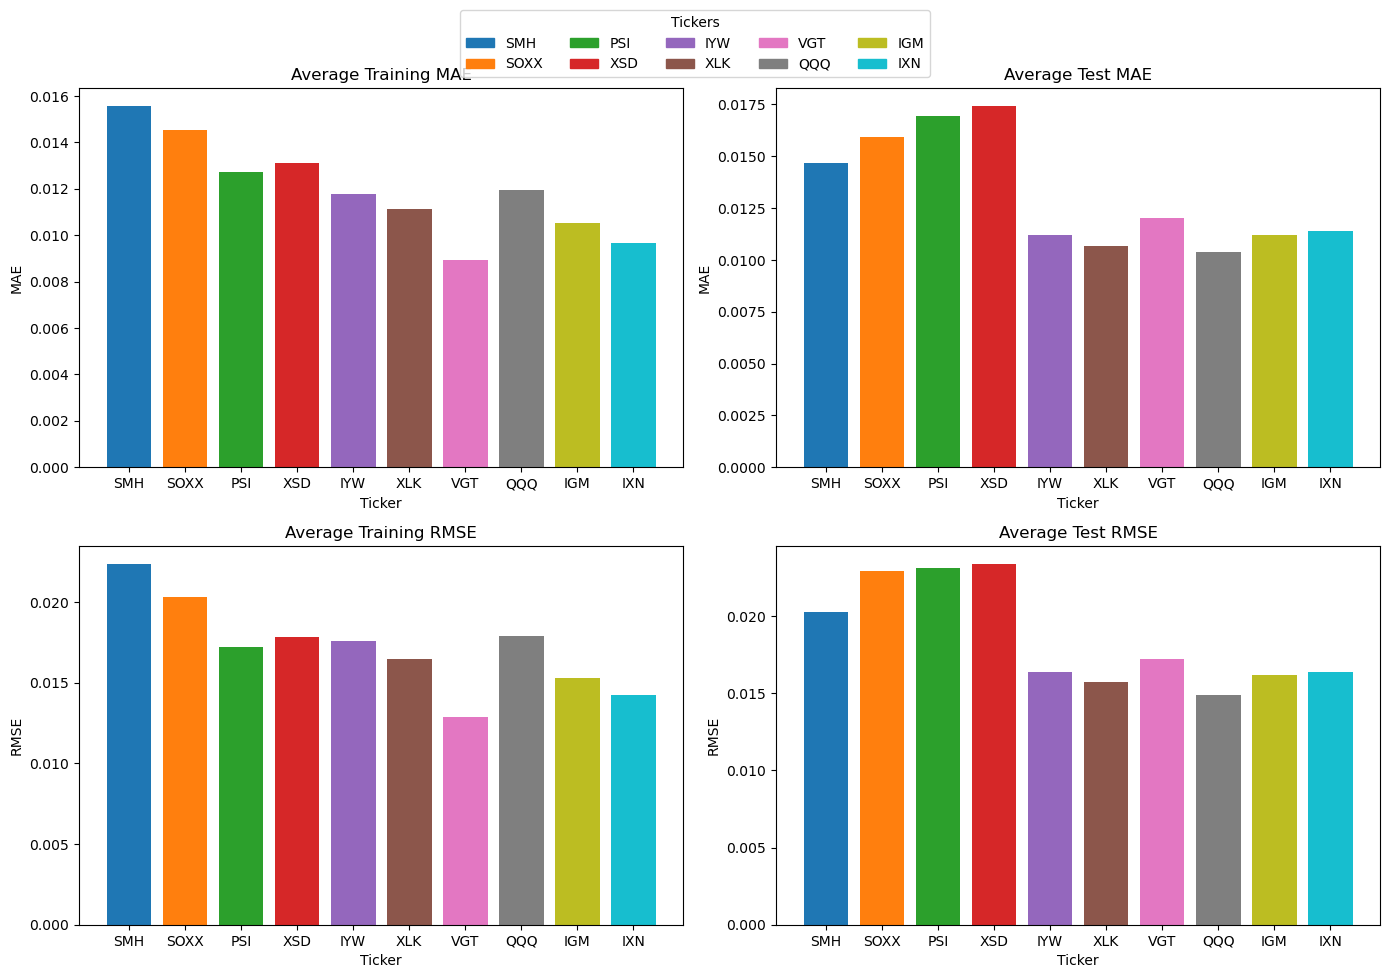

In [44]:
def plot_model_metrics(tickers, results):
    
    
    # --- 1. Gather metrics from 'results' for each ticker ---
    avg_training_mae = []
    avg_test_mae = []
    avg_training_rmse = []
    avg_test_rmse = []

    computation_time = []
    
    for ticker in tickers:
        model_metrics = results[ticker].get("model_metrics", {})
        
        train_set = model_metrics.get("training_set", {})
        test_set = model_metrics.get("test_set", {})
        
        avg_training_mae.append(train_set.get("mae", float('nan')))
        avg_test_mae.append(test_set.get("mae", float('nan')))
        avg_training_rmse.append(train_set.get("rmse", float('nan')))
        avg_test_rmse.append(test_set.get("rmse", float('nan')))

        computation_time.append(results[ticker].get("model_metrics", {}).get("time", {})) 
    
    # (Optional) Print some global averages if you want
    print("Overall mean Training MAE:", mean(avg_training_mae))
    print("Overall mean Test MAE:", mean(avg_test_mae))
    print("Overall mean Training RMSE:", mean(avg_training_rmse))
    print("Overall mean Test RMSE:", mean(avg_test_rmse))

    print(f"Total time elapsed to run the model: {sum(computation_time):.2f} seconds" )
    print(f"Average time consumed by model to train on an ETF: {mean(computation_time):.2f} seconds", )
    # --- 2. Define a color palette for each ticker (must match the number of tickers) ---
    # Example: 10 distinct colors
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    # If you have more than 10 tickers, you need more colors or a different approach.

    # --- 3. Set up a 2×2 subplot grid ---
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    x_positions = range(len(tickers))  # One position per ticker

    # --- Subplot 1: Average Training MAE ---
    ax = axs[0, 0]
    ax.bar(x_positions, avg_training_mae, color=colors[:len(tickers)])
    ax.set_title("Average Training MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 2: Average Test MAE ---
    ax = axs[0, 1]
    ax.bar(x_positions, avg_test_mae, color=colors[:len(tickers)])
    ax.set_title("Average Test MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 3: Average Training RMSE ---
    ax = axs[1, 0]
    ax.bar(x_positions, avg_training_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Training RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 4: Average Test RMSE ---
    ax = axs[1, 1]
    ax.bar(x_positions, avg_test_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Test RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- 4. Create a single legend for the entire figure ---
    legend_handles = [
        mpatches.Patch(color=c, label=ticker)
        for c, ticker in zip(colors[:len(tickers)], tickers)
    ]
    # Adjust spacing to make room at the top for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.93])

    fig.legend(
        handles=legend_handles,
        title="Tickers",
        loc="upper center",
        bbox_to_anchor=(0.5, 0.98),
        ncol=min(5, len(tickers))  # Use up to 5 columns or fewer if <5 tickers
    )

    plt.show()
tickers = ['SMH', 'SOXX', 'PSI', 'XSD', 'IYW', 'XLK', 'VGT', 'QQQ', 'IGM', 'IXN']

plot_model_metrics(tickers, results)

In [45]:
def calculate_sharpe_ratio(returns, annual_risk_free_rate=0.1,period='daily'):
    #excess_returns = rate_of_return(returns) - risk_free_rate
    
    # Convert annual risk-free rate to daily rate
    daily_risk_free_rate = (1 + annual_risk_free_rate) ** (1/252) - 1
    
    # Calculate mean daily log return
    mean_return = np.mean(returns)
    
    # Calculate excess daily log return
    excess_return = mean_return - daily_risk_free_rate
    
    # Calculate standard deviation of daily log returns
    std_return = np.std(returns)
    
    # Print diagnostic information
    #print(f"Mean Daily Log Return: {mean_return}")
    #print(f"Excess Daily Log Return: {excess_return}")
    #print(f"Standard Deviation of Daily Log Returns: {std_return}")
    epsilon = 0
    # Check for zero standard deviation to avoid division by zero
    if std_return == 0:
        epsilon = 1e-5 
    
    # Calculate Sharpe ratio
    #sharpe_ratio = (excess_return / std_return) * np.sqrt(252)  # Annualize the Sharpe ratio
    sharpe_ratio = (excess_return / (std_return +  epsilon)) # Annualize the Sharpe ratio

    return sharpe_ratio
    #return excess_returns / np.std(returns)


def calculate_rachev_ratio(returns, lower_percentile=5, upper_percentile=95):
    # Step 1: Sort the returns
    sorted_returns = np.sort(returns)
    
    # Step 2: Determine the percentiles
    lower_threshold = np.percentile(sorted_returns, lower_percentile)
    upper_threshold = np.percentile(sorted_returns, upper_percentile)
    
    # Step 3: Calculate Expected Shortfall (ES)
    es = np.mean(sorted_returns[sorted_returns <= lower_threshold])
    
    # Step 4: Calculate Expected Gain (EG)
    eg = np.mean(sorted_returns[sorted_returns >= upper_threshold])
    
    # Step 5: Compute the Rachev Ratio
    rachev_ratio = eg / -es
    return rachev_ratio


"""def calculate_volatility_clustering(returns):
    squared_returns = returns ** 2
    n = len(squared_returns)
    
    # Mean of squared returns
    mean_squared_returns = np.mean(squared_returns)
    
    # Calculate the numerator and denominator for autocorrelation at lag 1
    numerator = np.sum((squared_returns[:-1] - mean_squared_returns) * (squared_returns[1:] - mean_squared_returns))
    denominator = np.sum((squared_returns - mean_squared_returns) ** 2)
    
    if denominator == 0:
        return 0  # Avoid division by zero
    
    rho_1 = numerator / denominator
    return rho_1"""
def calculate_volatility_clustering(returns):
    # Ensure returns is a NumPy array
    returns = np.array(returns)
    squared_returns = returns ** 2
    n = len(squared_returns)

    # Mean of squared returns
    mean_squared = np.mean(squared_returns)
    clustering = np.sum((squared_returns - mean_squared) ** 2) / (n - 1 if n > 1 else 1)
    return clustering

def calculate_sortino_ratio(log_returns, target_log_return=0.04):
    """
    Calculate the Sortino Ratio using log returns.
    
    Parameters:
    - log_returns (array-like): Array or list of log returns for the period.
    - target_log_return (float): The target log return. Default is 0, which is often used as a benchmark.
    
    Returns:
    - float: The Sortino Ratio.
    """
    # Convert input to a NumPy array for easier calculations
    log_returns = np.array(log_returns)
    
    # Calculate the average period log return (R)
    avg_log_return = np.mean(log_returns)
    
    # Calculate the Target Downside Deviation (TDD)
    downside_deviation = np.sqrt(
        np.mean(np.square(np.maximum(0, target_log_return - log_returns)))
    )
    
    # Calculate Sortino Ratio
    #sortino_ratio_value = (avg_log_return - target_log_return) / downside_deviation
    epsilon = 1e-8
    
    # Add epsilon to downside_deviation to prevent division by zero
    #if downside_deviation == 0:
     #   return np.nan  # Return NaN if downside deviation is zero
    
    # Calculate Sortino Ratio
    sortino_ratio_value = (avg_log_return - target_log_return) / (downside_deviation + epsilon)
    
    return sortino_ratio_value


def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        for month in range(1, 13):
            future_predictions = data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            risk_metrics_results[ticker][f'risk_metrics_{month}m'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
            #print(risk_metrics_results)
    return risk_metrics_results


In [46]:
def calculate_composite_score(
    forecasted_values, risk_percentage, rachev_ratio, sharpe_ratio, sortino_ratio, volatility_clustering, 
    mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, 
    mean_volatility_clustering, std_volatility_clustering
):
    epsilon = 1e-8  # To prevent division by zero
    forecasted_mean = np.mean(forecasted_values)

    # Normalize the components with epsilon
    forecasted_mean_normalized = (forecasted_mean - mean_forecast) / (std_forecast + epsilon)
    rachev_normalized = (rachev_ratio - mean_rachev) / (std_rachev + epsilon)
    sharpe_normalized = (sharpe_ratio - mean_sharpe) / (std_sharpe + epsilon)
    sortino_normalized = (sortino_ratio - mean_sortino) / (std_sortino + epsilon)
    volatility_clustering_normalized = (volatility_clustering - mean_volatility_clustering) / (std_volatility_clustering + epsilon)

    # Composite score calculation
    score = (
        forecasted_mean_normalized
        - (risk_percentage * rachev_normalized)
        + sharpe_normalized
        + sortino_normalized
        - volatility_clustering_normalized
    )

    return score

"""def compute_composite_scores(results, risk_metrics_results, risk_percentage):
    composite_scores = {}
    
    for month in range(1, 13):
        forecasted_values = {
            ticker: data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{month}m']
            composite_scores.setdefault(ticker, {})[f'composite_score_{month}m'] = calculate_composite_score(
                forecasted_values[ticker], risk_percentage, risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                np.mean([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()])
            )
    
    return composite_scores"""

def compute_composite_scores(results, risk_metrics_results, risk_percentages):
    composite_scores = {}
    aggregated_scores = {}
    
    for month in range(1, 13):
        forecasted_values = {
            ticker: data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{month}m']
            composite_scores.setdefault(ticker, {})[f'composite_scores_{month}m'] = {}
            
            for risk_percentage in risk_percentages:
                score = calculate_composite_score(
                    forecasted_values[ticker], risk_percentage, risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                    risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                    np.mean([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()])
                )
                composite_scores[ticker][f'composite_scores_{month}m'][risk_percentage] = score
        
        # Compute aggregated scores per ETF per month
        for ticker in composite_scores:
            aggregated_scores.setdefault(ticker, {})[f'aggregated_score_{month}m'] = np.mean(
                list(composite_scores[ticker][f'composite_scores_{month}m'].values())
            )
    print(composite_scores)
    #return composite_scores, aggregated_scores
    return aggregated_scores

In [47]:
#risk_metrics_results2 = compute_risk_metrics(results2)
#compute_composite_scores(results2, risk_metrics_results2, 0.1)

In [48]:
def select_top_etfs_monthly(df, month_label, return_scores=False):
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        return list(df_sorted.itertuples(index=False, name=None))  # Returns tuples (ETF, Score)
    return list(df_sorted['ETF'])  # Returns only ETF names

def generate_month_ranges(start_date, end_date):
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    month_ranges = []
    while start < end:
        month_start = start
        month_end = (start + timedelta(days=31)).replace(day=1) - timedelta(days=1)
        if month_end > end:
            month_end = end
        month_ranges.append((month_start.strftime('%Y-%m-%d'), month_end.strftime('%Y-%m-%d')))
        start = month_end + timedelta(days=1)
    return month_ranges

def gather_etf_data(tickers, month_ranges):
    etf_histories = {}
    for start_date, end_date in month_ranges:
        month = f"{start_date} to {end_date}"
        etf_histories[month] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            etf_data.columns = etf_data.columns.get_level_values(0)
            if etf_data.empty:
                print(f"No data found for {ticker} in {month}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[month][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, month, investment_amount=50000):
    ticker_shares = {}
    first_trading_day_start = month.split(" to ")[0]
    for ticker in top_etfs:
        etf_history = etf_histories.get(month, {}).get(ticker)
        if etf_history is not None:
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            if first_trading_day not in etf_history.index:
                first_trading_day = etf_history.index[etf_history.index.searchsorted(first_trading_day)]
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {month}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_month, curr_month, ticker_shares, etf_histories):
    print(f"Top 2 ETFs for {prev_month}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_month}: {curr_top_etfs}")
    etf_histories_curr = etf_histories.get(curr_month, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs
    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr:
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")
    print(f"Updated ticker shares after {curr_month}: {ticker_shares}")
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}

'''def portfolio(results, risk_percentage=0.2):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    portfolios = {
        str(month): select_top_etfs_monthly(
            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),
            f'{month}m'
        ) for month in range(1, 13)
    }
    return portfolios'''

'''def portfolio(results, risk_percentage=0.1, return_scores=False):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    
    portfolios = {
        str(month): select_top_etfs_monthly(
            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),
            f'{month}m',
            return_scores=return_scores
        ) for month in range(1, 13)
    }
    return portfolios
'''



"def portfolio(results, risk_percentage=0.1, return_scores=False):\n    risk_metrics_results = compute_risk_metrics(results)\n    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)\n    \n    portfolios = {\n        str(month): select_top_etfs_monthly(\n            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),\n            f'{month}m',\n            return_scores=return_scores\n        ) for month in range(1, 13)\n    }\n    return portfolios\n"

In [49]:

def calculate_smoothing(scores_dict, alpha=0.1):
    smoothed_scores = {}
    previous_values = {}
    sorted_months = sorted(scores_dict.keys(), key=lambda m: int(m))
    for month in sorted_months:
        smoothed_scores[month] = {}
        for etf, raw_score in scores_dict[month].items():
            if etf not in previous_values:
                smoothed_value = float(raw_score)
            else:
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[month][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    return smoothed_scores

def portfolio(results, risk_percentages, return_scores=False):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentages)
    
    # Store all ETF scores per month instead of only top 2 ETFs
    all_scores_per_month = {
        str(month): {
            etf: composite_scores[etf][f'aggregated_score_{month}m']
            for etf in composite_scores
        }
        for month in range(1, 13)
    }
    
    return all_scores_per_month


def portfolio_optimization(results, risk_percentages, smoothing=False):
    all_scores = portfolio(results, risk_percentages, return_scores=True)
    print("\n--- Raw Scores Before Smoothing ---")
    for month, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {scores}")
    
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for month, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Month {month}: {scores}")
        
        # Use smoothed scores to select top 2 ETFs per month
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores if no smoothing
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for month, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {etfs}")
    
    month_ranges = generate_month_ranges('2024-01-01', '2025-01-01')
    etf_histories = gather_etf_data(results.keys(), month_ranges)
    ticker_shares = {}
    ticker_shares_per_month = {}
    
    for i, month_range in enumerate(etf_histories.keys()):
        month_index = str(i + 1)
        top_etfs = portfolios.get(month_index, [])
        if not top_etfs:
            print(f"Warning: No ETFs selected for {month_range}. Skipping trading.")
            continue
        if i == 0:
            ticker_shares = initialize_shares(top_etfs, etf_histories, month_range)
        else:
            prev_month_index = str(i)
            prev_top_etfs = portfolios.get(prev_month_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                month_range,
                ticker_shares,
                etf_histories
            )
        ticker_shares_per_month[month_range] = ticker_shares.copy()
    
    first_trading_day_13m = '2025-01-01'
    month_12_range = list(ticker_shares_per_month.keys())[-1]
    month_13_start = first_trading_day_13m
    month_13_end = '2025-01-06'
    etf_values_13m = {}
    
    if month_12_range in ticker_shares_per_month:
        ticker_shares_12m = ticker_shares_per_month[month_12_range]
        for ticker, shares in ticker_shares_12m.items():
            data = yf.download(ticker, start=month_13_start, end=month_13_end)
            data.columns = data.columns.get_level_values(0)

            if not data.empty:
                closing_price_13m = data['Close'].iloc[0]
                total_value = shares * closing_price_13m
                etf_values_13m[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_13m.values()) if etf_values_13m else 0
    return ticker_shares_per_month, total_portfolio_value


In [50]:

portfolios, final_value = portfolio_optimization(results, risk_percentages=[0.01, 0.04, 0.1, 0.2], smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")

{'SMH': {'composite_scores_1m': {0.01: 0.007057100878169853, 0.04: 0.024029332276256365, 0.1: 0.0579737950724295, 0.2: 0.11454789973271795}, 'composite_scores_2m': {0.01: -0.4260870104444349, 0.04: -0.4158368652713207, 0.1: -0.3953365749250922, 0.2: -0.3611694243480447}, 'composite_scores_3m': {0.01: -0.6792666379741583, 0.04: -0.6758207602580327, 0.1: -0.6689290048257813, 0.2: -0.6574427457720291}, 'composite_scores_4m': {0.01: -0.6308645042828365, 0.04: -0.6209211024029861, 0.1: -0.6010342986432854, 0.2: -0.5678896257104509}, 'composite_scores_5m': {0.01: -0.6194545529512551, 0.04: -0.6194024812619635, 0.1: -0.6192983378833803, 0.2: -0.6191247655857417}, 'composite_scores_6m': {0.01: -0.6458509398122289, 0.04: -0.6489013629961524, 0.1: -0.6550022093639998, 0.2: -0.6651702866437453}, 'composite_scores_7m': {0.01: -0.7742197681875461, 0.04: -0.7671975574798174, 0.1: -0.7531531360643601, 0.2: -0.7297457670385978}, 'composite_scores_8m': {0.01: -0.8231748619620596, 0.04: -0.8179494260375

[*********************100%***********************]  1 of 1 completed

Buy IXN: 755.40 shares at 66.02.
Buy IYW: 418.23 shares at 119.25.
Top 2 ETFs for 2024-01-01 to 2024-01-31: ['IXN', 'IYW']
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['IXN', 'QQQ']
Sell IYW: 418.23 shares at 127.59. Total value: 53230.17
Buy QQQ: 126.61 shares at 419.39.
Updated ticker shares after 2024-02-01 to 2024-02-29: {'IXN': 755.3961024374325, 'QQQ': 126.60621576363624}
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['IXN', 'QQQ']
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['IXN', 'QQQ']
Updated ticker shares after 2024-03-01 to 2024-03-31: {'IXN': 755.3961024374325, 'QQQ': 126.60621576363624}
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['IXN', 'QQQ']
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['IXN', 'QQQ']
Updated ticker shares after 2024-04-01 to 2024-04-30: {'IXN': 755.3961024374325, 'QQQ': 126.60621576363624}
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['IXN', 'QQQ']
Top 2 ETFs for 2024-05-01 to 2024-05-31: ['IXN', 'QQQ']
Updated ticker shares after 2024-05-01 to 2024-05-31: {'IXN': 755.3961


[*********************100%***********************]  1 of 1 completed

Final Portfolio Value: 128436.82


In [51]:

portfolios, final_value = portfolio_optimization(results,risk_percentages=[0.01, 0.04, 0.1, 0.2], smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")

{'SMH': {'composite_scores_1m': {0.01: 0.007057100878169853, 0.04: 0.024029332276256365, 0.1: 0.0579737950724295, 0.2: 0.11454789973271795}, 'composite_scores_2m': {0.01: -0.4260870104444349, 0.04: -0.4158368652713207, 0.1: -0.3953365749250922, 0.2: -0.3611694243480447}, 'composite_scores_3m': {0.01: -0.6792666379741583, 0.04: -0.6758207602580327, 0.1: -0.6689290048257813, 0.2: -0.6574427457720291}, 'composite_scores_4m': {0.01: -0.6308645042828365, 0.04: -0.6209211024029861, 0.1: -0.6010342986432854, 0.2: -0.5678896257104509}, 'composite_scores_5m': {0.01: -0.6194545529512551, 0.04: -0.6194024812619635, 0.1: -0.6192983378833803, 0.2: -0.6191247655857417}, 'composite_scores_6m': {0.01: -0.6458509398122289, 0.04: -0.6489013629961524, 0.1: -0.6550022093639998, 0.2: -0.6651702866437453}, 'composite_scores_7m': {0.01: -0.7742197681875461, 0.04: -0.7671975574798174, 0.1: -0.7531531360643601, 0.2: -0.7297457670385978}, 'composite_scores_8m': {0.01: -0.8231748619620596, 0.04: -0.8179494260375

[*********************100%***********************]  1 of 1 completed

Buy IXN: 755.40 shares at 66.02.
Buy IYW: 418.23 shares at 119.25.
Top 2 ETFs for 2024-01-01 to 2024-01-31: ['IXN', 'IYW']
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['SOXX', 'IXN']
Sell IYW: 418.23 shares at 127.59. Total value: 53230.17
Buy SOXX: 272.18 shares at 195.08.
Updated ticker shares after 2024-02-01 to 2024-02-29: {'IXN': 755.3961024374325, 'SOXX': 272.1765303325102}
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['SOXX', 'IXN']
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['QQQ', 'IXN']
Sell SOXX: 272.18 shares at 225.19. Total value: 61138.10
Buy QQQ: 137.67 shares at 442.98.
Updated ticker shares after 2024-03-01 to 2024-03-31: {'IXN': 755.3961024374325, 'QQQ': 137.67120590805266}
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['QQQ', 'IXN']
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['IXN', 'QQQ']
Updated ticker shares after 2024-04-01 to 2024-04-30: {'QQQ': 137.67120590805266, 'IXN': 755.3961024374325}
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['IXN', 'QQQ']
Top 2 ETFs for 2024-05-01 to 20


[*********************100%***********************]  1 of 1 completed

Final Portfolio Value: 134082.51


In [52]:
import numpy as np

def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        # Change range(1, 13) to range(1, 53) and month -> week
        for week in range(1, 54):
            # Change 'monthly_forecast_results' to 'weekly_forecast_results' 
            # and '{month}m' to '{week}w'
            future_predictions = data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            # Rename 'risk_metrics_{month}m' to 'risk_metrics_{week}w'
            risk_metrics_results[ticker][f'risk_metrics_{week}w'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    return risk_metrics_results

def compute_composite_scores(results, risk_metrics_results, risk_percentages):
    composite_scores = {}
    aggregated_scores = {}
    
    for week in range(1, 53):
        forecasted_values = {
            ticker: data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{week}w']
            composite_scores.setdefault(ticker, {})[f'composite_scores_{week}w'] = {}
            
            for risk_percentage in risk_percentages:
                score = calculate_composite_score(
                    forecasted_values[ticker], risk_percentage, risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                    risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                    np.mean([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                    np.mean([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                    np.std([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()])
                )
                composite_scores[ticker][f'composite_scores_{week}w'][risk_percentage] = score
        
        # Compute aggregated scores per ETF per month
        for ticker in composite_scores:
            aggregated_scores.setdefault(ticker, {})[f'aggregated_score_{week}w'] = np.mean(
                list(composite_scores[ticker][f'composite_scores_{week}w'].values())
            )
    print(composite_scores)
    #return composite_scores, aggregated_scores
    return aggregated_scores


In [53]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

def select_top_etfs_weekly(df, week_label, return_scores=False):
    """
    Select the top 2 ETFs based on 'Score' for the given week_label.
    """
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        # Returns list of tuples (ETF, Score)
        return list(df_sorted.itertuples(index=False, name=None))
    # Returns only ETF names
    return list(df_sorted['ETF'])

def generate_week_ranges(start_date, end_date):
    """
    Generate a list of weekly date ranges from start_date to end_date.
    Each range is 7 days long (e.g., Monday to Sunday).
    """
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    week_ranges = []
    
    while start < end:
        week_start = start
        # Each period is one week long (7 days)
        week_end = start + timedelta(days=6)
        # If the next 7-day block goes beyond end, truncate to end
        if week_end > end:
            week_end = end
        week_ranges.append((week_start.strftime('%Y-%m-%d'), week_end.strftime('%Y-%m-%d')))
        
        # Move to the day after week_end to start the next week
        start = week_end + timedelta(days=1)
    
    return week_ranges

def gather_etf_data_weekly(tickers, week_ranges):
    """
    Download weekly ETF data for the specified tickers over the given weekly ranges.
    Returns a dictionary keyed by 'start_date to end_date', each containing data per ticker.
    """
    etf_histories = {}
    for start_date, end_date in week_ranges:
        week = f"{start_date} to {end_date}"
        etf_histories[week] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            etf_data.columns = etf_data.columns.get_level_values(0)

            if etf_data.empty:
                print(f"No data found for {ticker} in {week}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[week][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, week, investment_amount=50000):
    """
    Initialize shares for the top ETFs at the beginning of a given 'week'.
    """
    ticker_shares = {}
    # The 'week' string is in the format: "yyyy-mm-dd to yyyy-mm-dd"
    first_trading_day_start = week.split(" to ")[0]
    
    for ticker in top_etfs:
        etf_history = etf_histories.get(week, {}).get(ticker)
        if etf_history is not None and not etf_history.empty:
            # Move one business day forward from the week start
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            # If this exact date isn't in the index, find the nearest future trading day
            if first_trading_day not in etf_history.index:
                idx_pos = etf_history.index.searchsorted(first_trading_day)
                if idx_pos < len(etf_history.index):
                    first_trading_day = etf_history.index[idx_pos]
                else:
                    print(f"No valid trading day found for {ticker} in {week}")
                    continue
            
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price  # small friction cost (0.25%)
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {week}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_week, curr_week, ticker_shares, etf_histories):
    """
    Manage the transition from prev_week's top ETFs to curr_week's top ETFs,
    selling ETFs no longer in the top 2, and buying newly selected ETFs.
    """
    print(f"Top 2 ETFs for {prev_week}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_week}: {curr_top_etfs}")
    
    etf_histories_curr = etf_histories.get(curr_week, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs

    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr and not etf_histories_curr[etf].empty:
            # Use the first available Close price in the new week to sell
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")

    # Use zipped pairs to buy new ETFs using the proceeds from sold ETFs
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")

    print(f"Updated ticker shares after {curr_week}: {ticker_shares}")
    # Return only shares for the newly selected top ETFs
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}




In [54]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

def calculate_smoothing(scores_dict, alpha=0.1):
    """
    Apply exponential smoothing to a dictionary of dictionaries containing scores.
    Keys at the top level are weeks (as strings), and values are {etf: raw_score}.
    """
    smoothed_scores = {}
    previous_values = {}
    # Sort by the numeric value of the week string (e.g., '1', '2', ..., '52')
    sorted_weeks = sorted(scores_dict.keys(), key=lambda w: int(w))
    
    for week in sorted_weeks:
        smoothed_scores[week] = {}
        for etf, raw_score in scores_dict[week].items():
            if etf not in previous_values:
                # First time seeing this ETF, just take the raw score
                smoothed_value = float(raw_score)
            else:
                # Exponential smoothing
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[week][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    
    return smoothed_scores

def portfolio_weekly(results, risk_percentages, return_scores=False):
    """
    Compute risk metrics and composite scores on a weekly basis.
    Return a dictionary of all ETF scores per week (rather than just the top 2).
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentages)
    
    # Collect all ETF scores per week
    # Instead of composite_score_{month}m, we use composite_score_{week}w
    all_scores_per_week = {
        str(week): {
            etf: composite_scores[etf][f'aggregated_score_{week}w']
            for etf in composite_scores
        }
        for week in range(1, 53)  # 1 to 52 for weeks in a year, adjust as needed
    }
    
    return all_scores_per_week

def portfolio_optimization_weekly(results, risk_percentages, smoothing=False):
    """
    High-level function to:
      - Get all raw weekly scores
      - Optionally apply smoothing
      - Select top ETFs each week
      - Manage portfolio transitions through the weeks
      - Calculate final portfolio value after a certain 'week 53' period or next horizon
    """
    # 1) Get all raw weekly scores
    all_scores = portfolio_weekly(results, risk_percentages, return_scores=True)
    
    print("\n--- Raw Scores Before Smoothing ---")
    for week, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {scores}")
    
    # 2) Optionally apply smoothing
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for week, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Week {week}: {scores}")
        
        # Select top 2 ETFs based on smoothed scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for week, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {etfs}")
    
    # 3) Gather weekly data for the actual buy/sell simulation
    #    Replace this range with your desired start/end for weekly intervals
    week_ranges = generate_week_ranges('2024-01-01', '2025-01-01')
    etf_histories = gather_etf_data_weekly(results.keys(), week_ranges)
    
    # Keep track of shares after each week
    ticker_shares = {}
    ticker_shares_per_week = {}
    
    # 4) Loop through the weeks in etf_histories
    for i, week_range in enumerate(etf_histories.keys()):
        week_index = str(i + 1)  # '1', '2', '3', ...
        top_etfs = portfolios.get(week_index, [])
        
        if not top_etfs:
            print(f"Warning: No ETFs selected for {week_range}. Skipping trading.")
            continue
        
        if i == 0:
            # First week: initialize shares
            ticker_shares = initialize_shares(top_etfs, etf_histories, week_range)
        else:
            # Manage portfolio transitions from previous week
            prev_week_index = str(i)
            prev_top_etfs = portfolios.get(prev_week_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                week_range,
                ticker_shares,
                etf_histories
            )
        
        ticker_shares_per_week[week_range] = ticker_shares.copy()
    
    # 5) Simulate final valuation after "Week 53" or any next horizon
    #    For illustration, let's say it's a few days into 2025.
    first_trading_day_53w = '2025-01-01'
    week_52_range = list(ticker_shares_per_week.keys())[-1] if ticker_shares_per_week else None
    
    # We can define a short window for the next week:
    week_53_start = first_trading_day_53w
    week_53_end = '2025-01-06'
    etf_values_53w = {}
    
    if week_52_range and week_52_range in ticker_shares_per_week:
        ticker_shares_52w = ticker_shares_per_week[week_52_range]
        for ticker, shares in ticker_shares_52w.items():
            data = yf.download(ticker, start=week_53_start, end=week_53_end, progress=False)
            data.columns = data.columns.get_level_values(0)

            
            if not data.empty:
                closing_price_53w = data['Close'].iloc[0]
                total_value = shares * closing_price_53w
                etf_values_53w[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_53w.values()) if etf_values_53w else 0
    
    return ticker_shares_per_week, total_portfolio_value


In [55]:

portfolios, final_value = portfolio_optimization_weekly(results,risk_percentages=[0.01, 0.04, 0.1, 0.2], smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")

{'SMH': {'composite_scores_1w': {0.01: 0.022207213759545652, 0.04: 0.028191125748690815, 0.1: 0.0401589497269812, 0.2: 0.06010532302413174}, 'composite_scores_2w': {0.01: -0.10745981462163495, 0.04: -0.08392421303188285, 0.1: -0.036853009852378604, 0.2: 0.041598995446795184}, 'composite_scores_3w': {0.01: 0.03338617324856363, 0.04: 0.03995654203381882, 0.1: 0.05309727960432914, 0.2: 0.074998508888513}, 'composite_scores_4w': {0.01: 0.05325523412087002, 0.04: 0.061518979396477935, 0.1: 0.07804646994769371, 0.2: 0.10559228753305333}, 'composite_scores_5w': {0.01: -0.12997404559668352, 0.04: -0.12145752028670413, 0.1: -0.10442446966674528, 0.2: -0.07603605196681389}, 'composite_scores_6w': {0.01: -0.45376259283030607, 0.04: -0.46631260011300946, 0.1: -0.49141261467841624, 0.2: -0.5332459722874275}, 'composite_scores_7w': {0.01: -0.6341598963157069, 0.04: -0.642778874867032, 0.1: -0.6600168319696822, 0.2: -0.6887467604740991}, 'composite_scores_8w': {0.01: -0.6882076499654189, 0.04: -0.691

Buy IXN: 755.40 shares at 66.02.
Buy IYW: 418.23 shares at 119.25.
Top 2 ETFs for 2024-01-01 to 2024-01-07: ['IXN', 'IYW']
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['IXN', 'IYW']
Updated ticker shares after 2024-01-08 to 2024-01-14: {'IXN': 755.3961024374325, 'IYW': 418.23283942500865}
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['IXN', 'IYW']
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['IXN', 'IYW']
Updated ticker shares after 2024-01-15 to 2024-01-21: {'IXN': 755.3961024374325, 'IYW': 418.23283942500865}
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['IXN', 'IYW']
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['IXN', 'IYW']
Updated ticker shares after 2024-01-22 to 2024-01-28: {'IXN': 755.3961024374325, 'IYW': 418.23283942500865}
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['IXN', 'IYW']
Top 2 ETFs for 2024-01-29 to 2024-02-04: ['IXN', 'QQQ']
Sell IYW: 418.23 shares at 130.52. Total value: 54449.79
Buy QQQ: 127.61 shares at 425.62.
Updated ticker shares after 2024-01-29 to 2024-02-04: {'IXN': 755.3961

Final Portfolio Value: 128083.77


In [56]:

portfolios, final_value = portfolio_optimization_weekly(results,risk_percentages=[0.01, 0.04, 0.1, 0.2], smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")

{'SMH': {'composite_scores_1w': {0.01: 0.022207213759545652, 0.04: 0.028191125748690815, 0.1: 0.0401589497269812, 0.2: 0.06010532302413174}, 'composite_scores_2w': {0.01: -0.10745981462163495, 0.04: -0.08392421303188285, 0.1: -0.036853009852378604, 0.2: 0.041598995446795184}, 'composite_scores_3w': {0.01: 0.03338617324856363, 0.04: 0.03995654203381882, 0.1: 0.05309727960432914, 0.2: 0.074998508888513}, 'composite_scores_4w': {0.01: 0.05325523412087002, 0.04: 0.061518979396477935, 0.1: 0.07804646994769371, 0.2: 0.10559228753305333}, 'composite_scores_5w': {0.01: -0.12997404559668352, 0.04: -0.12145752028670413, 0.1: -0.10442446966674528, 0.2: -0.07603605196681389}, 'composite_scores_6w': {0.01: -0.45376259283030607, 0.04: -0.46631260011300946, 0.1: -0.49141261467841624, 0.2: -0.5332459722874275}, 'composite_scores_7w': {0.01: -0.6341598963157069, 0.04: -0.642778874867032, 0.1: -0.6600168319696822, 0.2: -0.6887467604740991}, 'composite_scores_8w': {0.01: -0.6882076499654189, 0.04: -0.691

Buy IXN: 755.40 shares at 66.02.
Buy IYW: 418.23 shares at 119.25.
Top 2 ETFs for 2024-01-01 to 2024-01-07: ['IXN', 'IYW']
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['IXN', 'IGM']
Sell IYW: 418.23 shares at 120.47. Total value: 50258.14
Buy IGM: 681.50 shares at 73.56.
Updated ticker shares after 2024-01-08 to 2024-01-14: {'IXN': 755.3961024374325, 'IGM': 681.4989131376457}
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['IXN', 'IGM']
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['IXN', 'IYW']
Sell IGM: 681.50 shares at 75.27. Total value: 51169.14
Buy IYW: 414.69 shares at 123.08.
Updated ticker shares after 2024-01-15 to 2024-01-21: {'IXN': 755.3961024374325, 'IYW': 414.68894540628236}
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['IXN', 'IYW']
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['IXN', 'QQQ']
Sell IYW: 414.69 shares at 128.28. Total value: 53063.91
Buy QQQ: 126.26 shares at 419.24.
Updated ticker shares after 2024-01-22 to 2024-01-28: {'IXN': 755.3961024374325, 'QQQ': 126.25567083315042}
Top

Final Portfolio Value: 127452.38
